In [1]:
import shapely
import pandas as pd
from shapely.geometry import LineString
from shapely.geometry import Point
import osmnx as ox
import geopandas as gpd
from numpy.linalg import norm
import numpy as np
import math
from matplotlib import pyplot as plt
import contextily as cx
from pyproj.crs import CRS
import scipy
from datetime import timedelta
import pyproj

from shapely.ops import linemerge

import route2vel
import route2vel.utils as utils
from route2vel.loading import load_graph
import route2vel
from notebookutils import *

from route2vel.interp import *
from route2vel.route import *
from route2vel.classes import *

In [2]:
from route2vel.postprocess import *

In [3]:
%load_ext autoreload
%autoreload 2

In [14]:
plt.style.use('dark_background')
route2vel.load_config("..", force=True)
ox.settings.use_cache = False
cx.set_cache_dir(route2vel.cfg['resources_dir'] + '/contextily_cache')

In [9]:
route_steps = ["Zola Predosa", "Castel San Pietro Terme"]

In [10]:
direction = route2vel.find_route_osrm(route_steps, load_graph=True, load_graph_name='test_route_1')

Loading graph from d:\Documenti\Universita\tesim\route2vel\resources\graph\test_route_1.graphnx.pickle ...
Loaded in 0.38s!


In [11]:
print(f"Route length: {len(direction.geometry)} (osm nodes: {len(direction.nodelist())})")

Route length: 28 (osm nodes: 64)


In [12]:
interp_dir = route2vel.interp_from_route(direction)

ValueError: could not broadcast input array from shape (512,512,4) into shape (256,256,4)

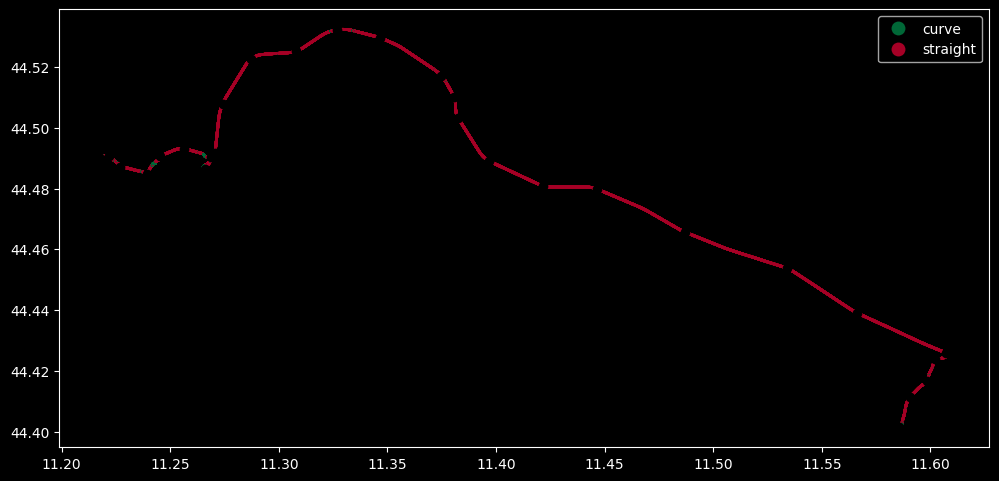

In [15]:
# interp_dir.plot()

In [16]:
gdf = interp_dir.split_gdf
gdf0 = gdf.to_crs(CRS(proj='utm', zone=32, units="m", ellipsis="WGS84"))
gdf1 = gpd.GeoDataFrame({
    "geometry": gdf0.geometry,
    "iscurve": gdf0.iscurve.astype(bool),
    "num": [len(line.coords) for line in gdf0.geometry],
    "length": [line.length for line in gdf0.geometry],
})
print("Not curve")
display(gdf1[~gdf1.iscurve].describe())
print("Curve")
display(gdf1[gdf1.iscurve].describe())

Not curve


,num,length
count,73.000000,73.000000
mean,8.424658,562.479287
std,16.881053,1946.818569
min,2.000000,15.205314
25%,2.000000,40.598774
50%,3.000000,79.385770
75%,6.000000,277.473994
max,88.000000,15206.729967


Curve


,num,length
count,59.000000,59.000000
mean,4.593220,32.618356
std,5.493315,49.628344
min,2.000000,2.183433
25%,2.000000,11.500422
50%,3.000000,14.657794
75%,5.000000,34.700605
max,38.000000,329.437955


In [26]:
meters_density = 0.1
pt_num = interp_dir.pt_num_for_density(meters_density)
print(f"For meters density {meters_density}m using {pt_num} points")

For meters density 0.1m using 430330 points


Testing with a roundabout tract (see [workflow_2.ipynb](./workflow_2.ipynb)).

In [27]:
route_bounds = ((11.237, 44.484), (11.242, 44.488))

In [28]:
# For testing, just crop the whole route instead of finding another shorter one
route2vel.utils.debug = True
gdf = interp_dir.get_points_with_num(pt_num, return_gdf=True, in_meters=True, gdf_columns=['base_idx', 'junction', 'speed_kph'])
proj_crs = gdf.crs
proj_crs

Projecting to UTM zone 32 (auto, from point [11.34890858 44.47679858])


<Projected CRS: +proj=utm +zone=32 +units=m +ellipsis +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
calc_curvature(gdf)

In [30]:
gdf.head()

,geometry,is_curve,split_gdf_index,base_idx,junction,speed_kph,curvature
0,POINT Z (676483.439 4928792.660 80.000),False,0,0,NaN,90.0,6.401164e-08
1,POINT Z (676483.529 4928792.639 80.005),False,0,0,NaN,90.0,4.052937e-08
2,POINT Z (676483.619 4928792.618 80.011),False,0,0,NaN,90.0,7.021058e-08
3,POINT Z (676483.709 4928792.597 80.016),False,0,0,NaN,90.0,2.046690e-07
4,POINT Z (676483.799 4928792.576 80.021),False,0,0,NaN,90.0,2.297010e-07


In [31]:
crop = clip_interp_gdf(gdf, route_bounds, Transformer.from_crs(direction.gdf.crs, proj_crs, always_xy=True).transform)
crop.describe()

,split_gdf_index,base_idx,speed_kph,curvature
count,5988.000000,5988.000000,5988.000000,5.988000e+03
mean,39.701570,22.956580,52.007348,2.072589e-02
std,3.047908,2.663674,8.781364,8.758402e-02
min,33.000000,17.000000,40.000000,2.655281e-08
25%,36.000000,20.000000,50.000000,1.407291e-07
50%,42.000000,25.000000,50.000000,1.619708e-07
75%,42.000000,25.000000,50.000000,8.104747e-03
max,44.000000,27.000000,90.000000,1.671359e+00


In [32]:
crop.head()

,geometry,is_curve,split_gdf_index,base_idx,junction,speed_kph,curvature
16361,POINT Z (677881.318 4928237.208 73.361),True,33,17,NaN,50.0,0.000643
16362,POINT Z (677881.407 4928237.182 73.368),True,33,17,NaN,50.0,0.000598
16363,POINT Z (677881.496 4928237.155 73.375),True,33,17,NaN,50.0,0.000554
16364,POINT Z (677881.585 4928237.128 73.382),True,33,17,NaN,50.0,0.000509
16365,POINT Z (677881.674 4928237.101 73.389),True,33,17,NaN,50.0,0.000464


In [33]:
print(f"Cropped points: {len(crop)}, {100 * len(crop) / len(gdf):.2f}%")

Cropped points: 5988, 1.39%


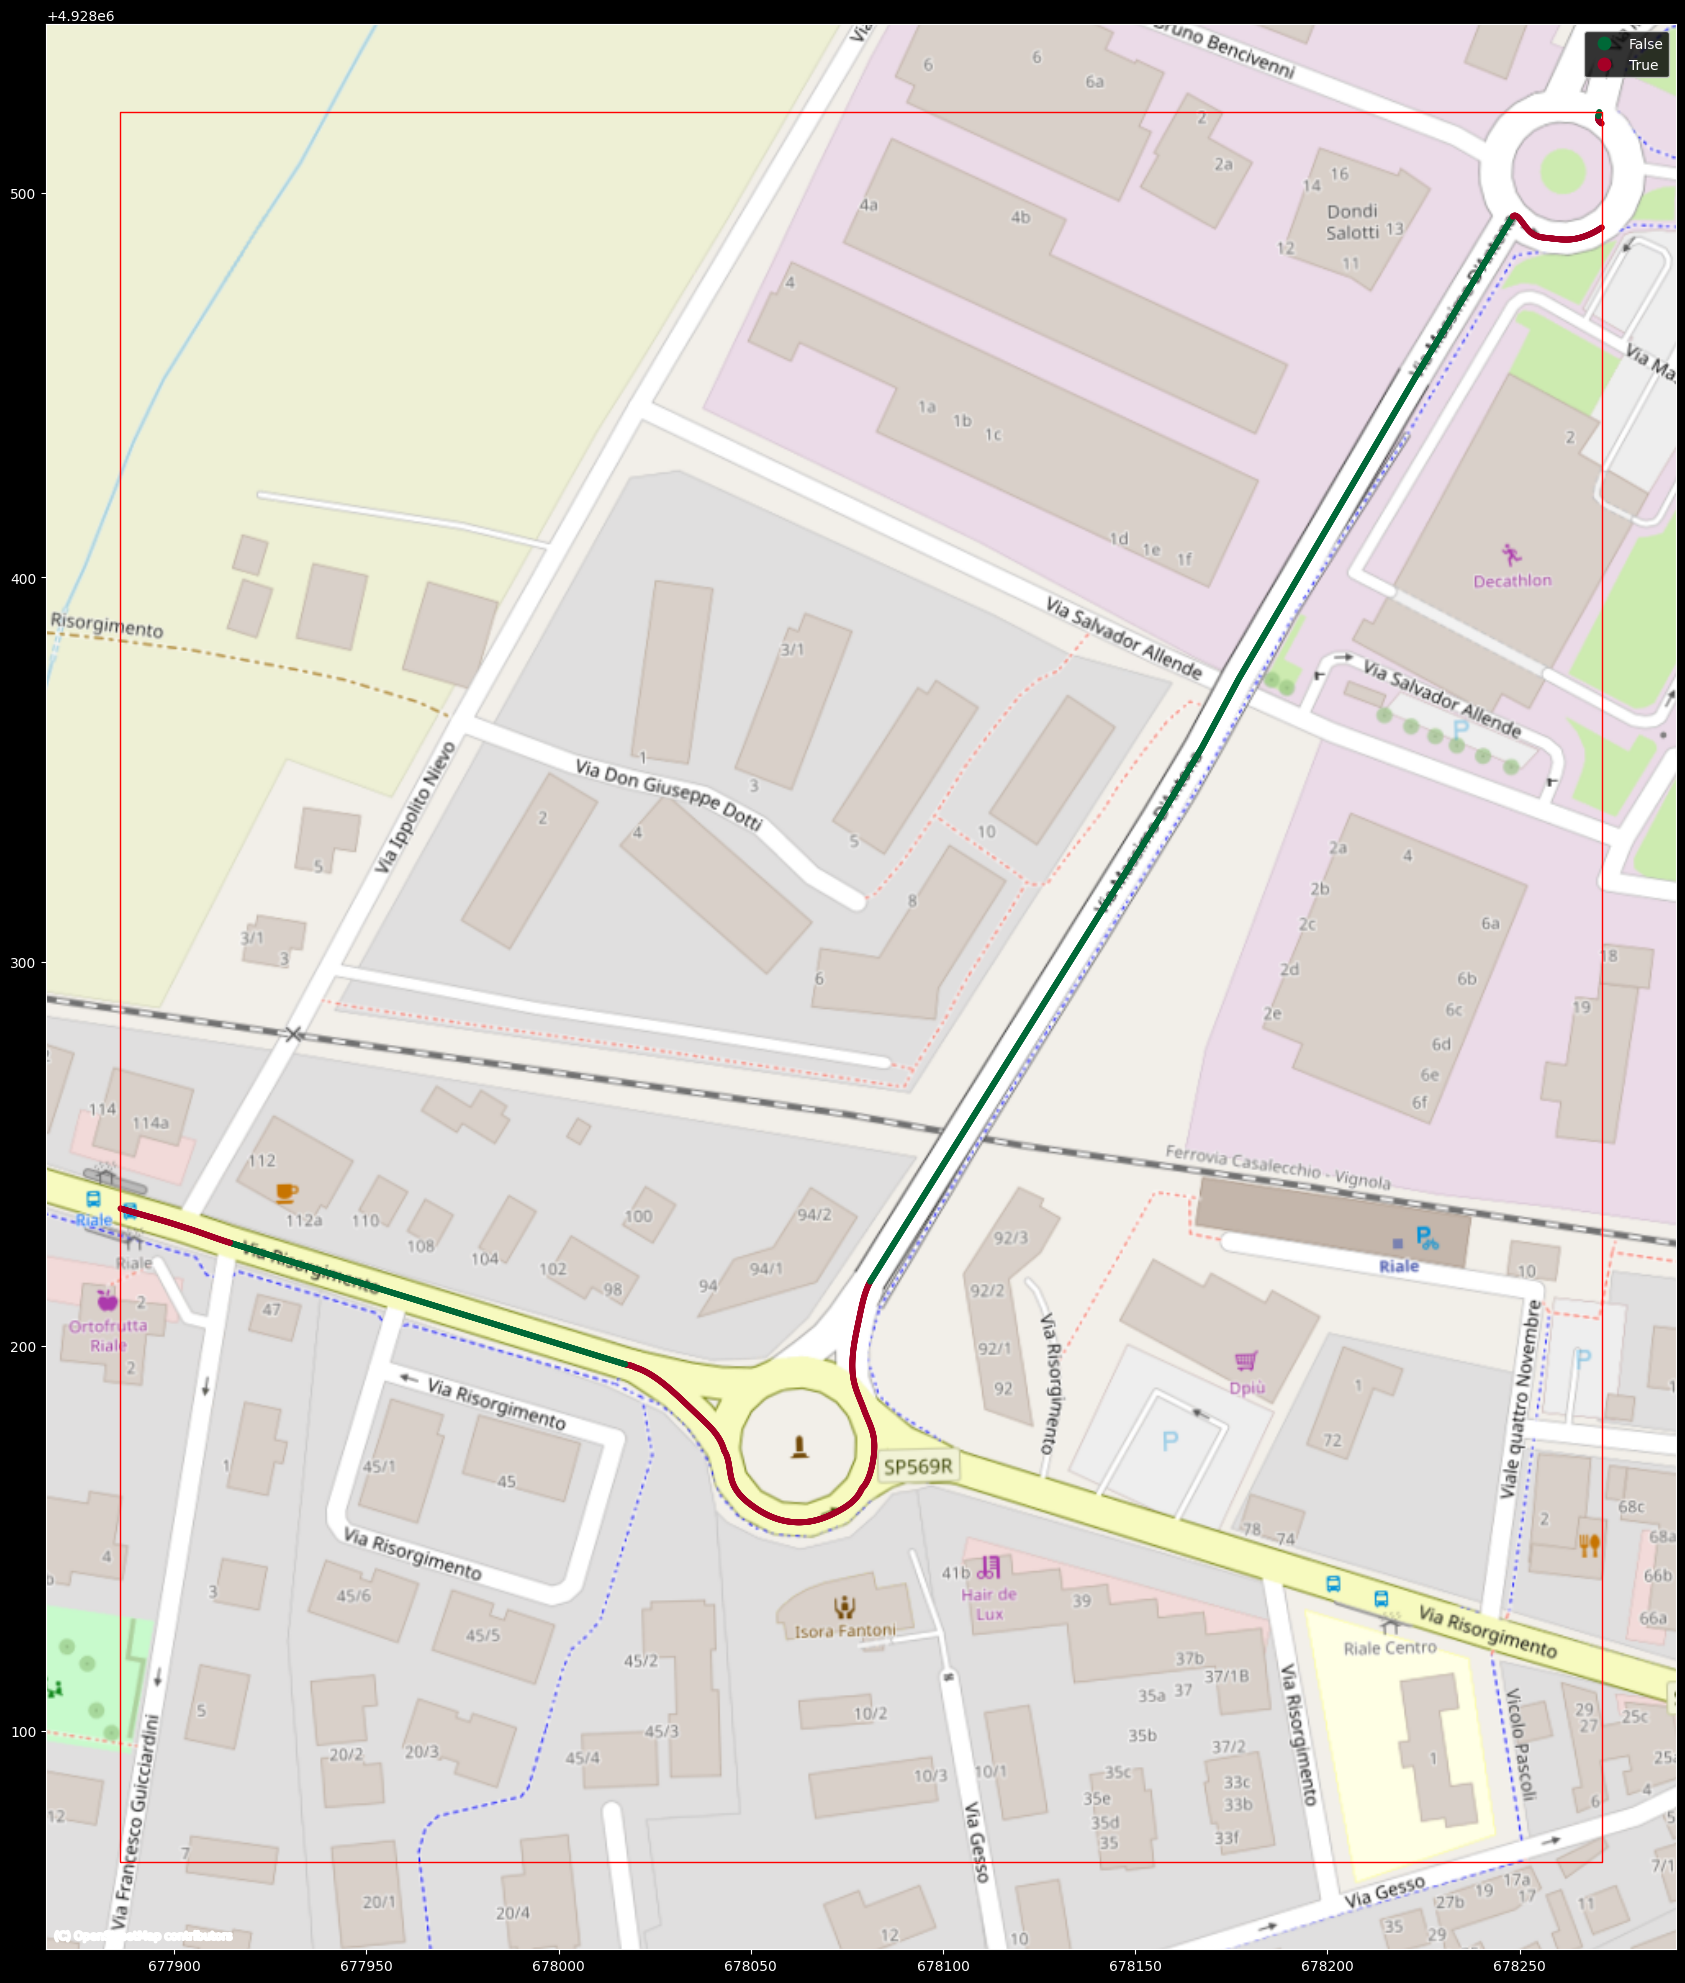

In [34]:
tr = pyproj.Transformer.from_crs(direction.gdf.crs, gdf.crs, always_xy=True).transform
display_bounded_shapes([
    # (gdf.reset_index(), {'column': 'is_curve', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r', 's': 10}, {
    #     "column": "index",
    #     "offset": (2, 4),
    #     "fontsize": 15
    # }),
    (gdf.reset_index(), {'column': 'is_curve', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r', 's': 10}),
], tr(*route_bounds[0]), tr(*route_bounds[1]), crs=gdf.crs, figsize=(25,25));

In [35]:
crop_offset = offset_meters_gdf(crop)
crop_offset.head()

,geometry,is_curve,split_gdf_index,base_idx,junction,speed_kph,curvature
16361,POINT Z (0.000 83.053 73.361),True,33,17,NaN,50.0,0.000643
16362,POINT Z (0.089 83.026 73.368),True,33,17,NaN,50.0,0.000598
16363,POINT Z (0.178 82.999 73.375),True,33,17,NaN,50.0,0.000554
16364,POINT Z (0.268 82.972 73.382),True,33,17,NaN,50.0,0.000509
16365,POINT Z (0.357 82.946 73.389),True,33,17,NaN,50.0,0.000464


In [36]:
fname = "../route_output.csv"
interp_gdf_to_csv(crop_offset, fname, separate_roundabout=True, add_tract_start_col=True, extra_cols=['speed_kph', 'curvature'])

Columns: ['lon', 'lat', 'ele', 'iscurve', 'start_line', 'speed_kph', 'curvature']
Written ../route_output.csv


In [37]:
fname = "../route_output_full.csv"
interp_gdf_to_csv(offset_meters_gdf(gdf), fname, separate_roundabout=True, add_tract_start_col=True, extra_cols=['speed_kph', 'curvature'])

Columns: ['lon', 'lat', 'ele', 'iscurve', 'start_line', 'speed_kph', 'curvature']
Written ../route_output_full.csv
